# Traffic Danger warning sign

---

- OUEDRAOGO Taoufiq
- NGNINTEDEM Lionel
- NANFAH Manoel
- TONDJI Andrea

In [2]:
import kagglehub
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

import pickle
import cv2
from tqdm import tqdm
from pylab import text
from PIL import Image
from skimage.transform import resize

# I. Download Data From Kaggle

In [2]:
# Download dataset used from Kaggle
dataset1 = "valentynsichkar/traffic-signs-dataset-in-yolo-format"
dataset2 = "valentynsichkar/traffic-signs-preprocessed"
#path = kagglehub.dataset_download(dataset1)

#print("Path to dataset files:", path)

Path to dataset files: /Users/taoufiq/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-dataset-in-yolo-format/versions/4


In [3]:
# Number of Images
len(os.listdir(path+'/ts/ts')) / 2

741.0

You are not obliged to run step 1. and 2. since the data has already been organized

## 1. Move data into our current folder

## 2. Split Files into "Danger" folder and "Others" folder

In [3]:
len_danger = len(os.listdir('./data/Classes/Danger'))
len_others = len(os.listdir('./data/Classes/Others'))
len_danger, len_others, len_danger + len_others

(165, 576, 741)

## 3. Visualization of Class

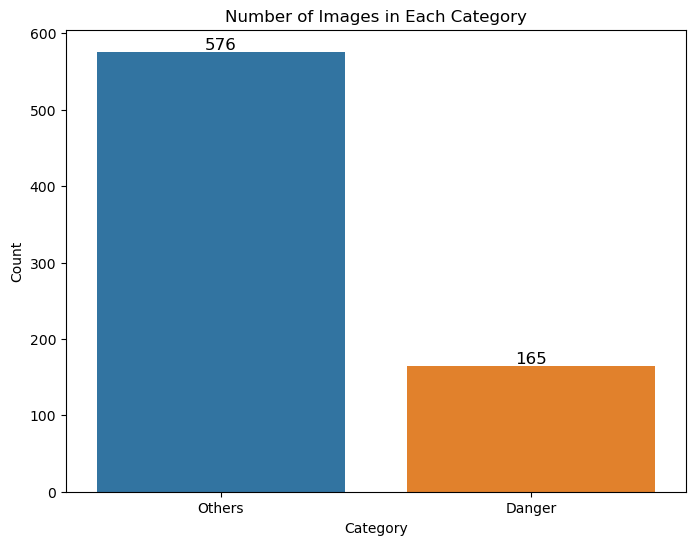

In [3]:
# Get the number of files in each directory
others_count = len(os.listdir('./data/Classes/Others'))
danger_count = len(os.listdir('./data/Classes/Danger'))

# Create a DataFrame for plotting
data = pd.DataFrame({'Category': ['Others', 'Danger'],
    'Count': [others_count, danger_count]})

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=data, hue='Category', legend=False)
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel('Count')

# Add the count value on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')
plt.show()

# II. Data Preparation

## 1. Data Generator

This code generates data generators for training, validation, and test sets using images and their corresponding labels stored in pandas DataFrames.

Each generator uses the flow_from_dataframe method from Keras’ ImageDataGenerator to load and preprocess the images, resizing them to a fixed size and batching them for efficient processing.

The training, validation, and test sets are handled separately using different DataFrames (train_images, val_images, and test_images), and each batch contains images and labels suitable for binary classification (0 or 1). 

These generators allow the model to train, validate, and test efficiently with preprocessed data.

In [4]:
# Configuration des chemins et des paramètres
data_dir = './data/Classes'  # Dossier contenant les sous-dossiers "Danger" et "Others"
img_height, img_width = 128, 128
batch_size = 32

# Générateur principal de données
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2
    #rotation_range=20,  # Randomly rotate images by up to 20 degrees
    #width_shift_range=0.2,  # Randomly shift images horizontally
    #height_shift_range=0.2,  # Randomly shift images vertically
    #shear_range=0.2,  # Shear images by up to 20%
   # zoom_range=0.2,  # Zoom into the images by up to 20%
  #  horizontal_flip=True,  # Randomly flip images horizontally
    #fill_mode='nearest',  # Filling missing pixels after transformations
)

# Charger les images et labels depuis les sous-dossiers
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True, 
    subset='training'
)

 
# Générer les sous-ensembles de validation  
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True, 
    subset='validation'
)

Found 593 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


# III. Modeling

This  initializes a convolutional neural network (CNN) for binary image classification. 

It starts by adding convolutional layers with ReLU activation and max-pooling layers to reduce the spatial dimensions of the feature maps. 

The network has three sets of convolutional layers, each followed by max-pooling. Afterward, the feature maps are flattened into a 1D vector using the Flatten layer. 

The model then adds two fully connected layers: one with 128 units and ReLU activation, and another with a single unit and a sigmoid activation function for binary classification. 

The model is compiled with the Adam optimizer, binary cross-entropy loss (appropriate for binary classification), and accuracy as a performance metric.

In [5]:
model1 = Sequential() # Initialization  

model1.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Flatten())  # Flattening 
model1.add(Dense(64, activation='relu'))    # Fully Connected Layer
model1.add(Dense(1, activation='sigmoid'))    # Sigmoid for binary classification 

# Compilation du modèle
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,417 (7.05 MB)

 Trainable params: 1,848,417 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history1 = model1.fit(train_generator, epochs=10, verbose=True, validation_data=validation_generator)

Traceback (most recent call last):
Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/j6/b2tmcfy95pbc2c4bh143v2dc0000gn/T/ipykernel_99467/3847604834.py", line 1, in <module>
    history1 = model1.fit(train_generator, epochs=10, verbose=True, validation_data=validation_generator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 282, in f

## Plot Loss and Accuracy

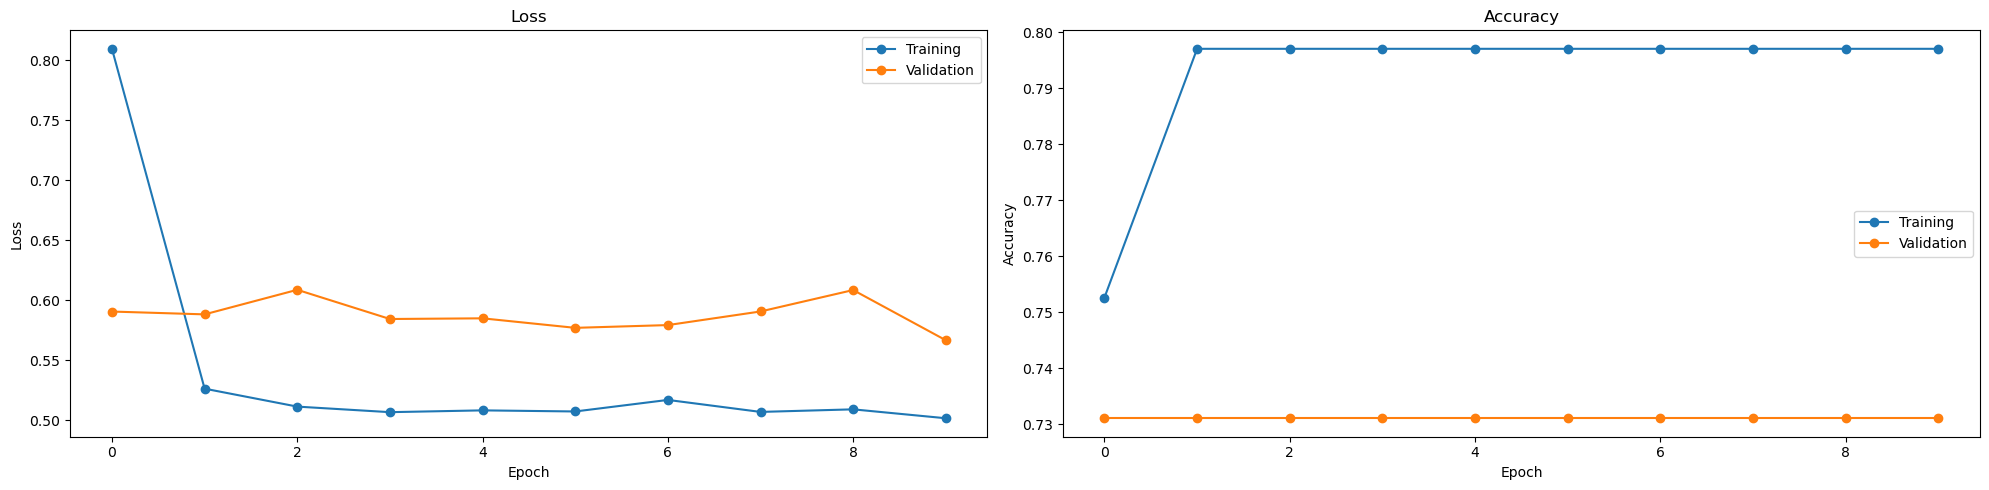

In [18]:
# Plot Loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training', marker='o')
plt.plot(history1.history['val_loss'], label='Validation', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Training', marker='o')
plt.plot(history1.history['val_accuracy'], label='Validation', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Analysis of results

Evolution of training accuracy: We can see that training accuracy increases over the epochs, indicating that the model is learning to better predict the training data. The training accuracy increases from 67.52% to 82.18% after 10 epochs, which is a significant improvement.

Evolution of training loss: The training loss gradually decreases from 0.9826 to 0.4650, which is a sign that the model is improving its predictions on the training data.

Validation accuracy and loss (val_accuracy and val_loss): The validation accuracy remains constant at 0.7311 and the validation loss varies slightly. This may suggest **overfitting**, as performance on the validation data does not improve whereas it does on the training data.


## Imbalanced Classes

Given the imbalanced classes in our dataset (“DANGER” with 165 instances and “OTHERS” with 576), the model might be biased toward predicting the majority class, “OTHERS.” This could explain why the model achieves high accuracy on training data but struggles on validation data, as it focuses on the majority class and neglects the minority class.
- The model tends to predict “OTHERS” more often, since it’s the majority class, leading to good accuracy but poor performance on “DANGER.”
- Accuracy Is Misleading: High accuracy doesn’t mean good performance for both classes. The model may perform well on “OTHERS” but fail on “DANGER.”

In [14]:
# Calculate class weights based on the labels
# Define the labels
labels = [0] * 576 + [1] * 165  # Assuming 0 = 'Others', 1 = 'Danger'

# Compute class weights using sklearn utility
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Convert to dictionary format expected by Keras
class_weight_dict = {str(i): class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{'0': 0.6432291666666666, '1': 2.2454545454545456}

In [50]:
history_w = model1.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=32, class_weight=class_weight_dict)

ValueError: Unrecognized data type: x=['./data/Classes/Others/00473.jpg', './data/Classes/Others/00367.jpg', './data/Classes/Danger/00858.jpg', './data/Classes/Others/00702.jpg', './data/Classes/Others/00436.jpg', './data/Classes/Others/00252.jpg', './data/Classes/Others/00468.jpg', './data/Classes/Others/00758.jpg', './data/Classes/Danger/00662.jpg', './data/Classes/Others/00502.jpg', './data/Classes/Others/00352.jpg', './data/Classes/Others/00206.jpg', './data/Classes/Others/00860.jpg', './data/Classes/Others/00360.jpg', './data/Classes/Others/00449.jpg', './data/Classes/Others/00236.jpg', './data/Classes/Others/00886.jpg', './data/Classes/Others/00733.jpg', './data/Classes/Others/00162.jpg', './data/Classes/Others/00887.jpg', './data/Classes/Others/00128.jpg', './data/Classes/Others/00317.jpg', './data/Classes/Danger/00100.jpg', './data/Classes/Others/00441.jpg', './data/Classes/Danger/00077.jpg', './data/Classes/Danger/00316.jpg', './data/Classes/Others/00268.jpg', './data/Classes/Others/00705.jpg', './data/Classes/Danger/00076.jpg', './data/Classes/Others/00593.jpg', './data/Classes/Others/00690.jpg', './data/Classes/Others/00124.jpg', './data/Classes/Others/00018.jpg', './data/Classes/Others/00477.jpg', './data/Classes/Others/00156.jpg', './data/Classes/Others/00411.jpg', './data/Classes/Others/00382.jpg', './data/Classes/Others/00825.jpg', './data/Classes/Others/00037.jpg', './data/Classes/Danger/00440.jpg', './data/Classes/Others/00496.jpg', './data/Classes/Others/00483.jpg', './data/Classes/Others/00234.jpg', './data/Classes/Others/00775.jpg', './data/Classes/Others/00667.jpg', './data/Classes/Others/00439.jpg', './data/Classes/Others/00668.jpg', './data/Classes/Danger/00807.jpg', './data/Classes/Others/00096.jpg', './data/Classes/Others/00177.jpg', './data/Classes/Others/00102.jpg', './data/Classes/Others/00253.jpg', './data/Classes/Others/00240.jpg', './data/Classes/Others/00080.jpg', './data/Classes/Others/00348.jpg', './data/Classes/Others/00570.jpg', './data/Classes/Danger/00481.jpg', './data/Classes/Others/00067.jpg', './data/Classes/Others/00203.jpg', './data/Classes/Others/00610.jpg', './data/Classes/Others/00026.jpg', './data/Classes/Others/00851.jpg', './data/Classes/Danger/00864.jpg', './data/Classes/Danger/00697.jpg', './data/Classes/Others/00624.jpg', './data/Classes/Others/00262.jpg', './data/Classes/Others/00344.jpg', './data/Classes/Others/00152.jpg', './data/Classes/Others/00798.jpg', './data/Classes/Others/00896.jpg', './data/Classes/Others/00283.jpg', './data/Classes/Danger/00845.jpg', './data/Classes/Others/00027.jpg', './data/Classes/Danger/00070.jpg', './data/Classes/Others/00379.jpg', './data/Classes/Others/00695.jpg', './data/Classes/Others/00762.jpg', './data/Classes/Danger/00148.jpg', './data/Classes/Others/00884.jpg', './data/Classes/Others/00854.jpg', './data/Classes/Danger/00492.jpg', './data/Classes/Others/00478.jpg', './data/Classes/Others/00373.jpg', './data/Classes/Others/00048.jpg', './data/Classes/Others/00725.jpg', './data/Classes/Others/00694.jpg', './data/Classes/Others/00730.jpg', './data/Classes/Others/00524.jpg', './data/Classes/Others/00686.jpg', './data/Classes/Others/00005.jpg', './data/Classes/Others/00242.jpg', './data/Classes/Others/00138.jpg', './data/Classes/Others/00612.jpg', './data/Classes/Others/00761.jpg', './data/Classes/Others/00794.jpg', './data/Classes/Danger/00398.jpg', './data/Classes/Others/00485.jpg', './data/Classes/Danger/00282.jpg', './data/Classes/Others/00885.jpg', './data/Classes/Others/00611.jpg', './data/Classes/Danger/00703.jpg', './data/Classes/Others/00154.jpg', './data/Classes/Danger/00073.jpg', './data/Classes/Danger/00544.jpg', './data/Classes/Others/00284.jpg', './data/Classes/Others/00210.jpg', './data/Classes/Others/00760.jpg', './data/Classes/Others/00778.jpg', './data/Classes/Others/00340.jpg', './data/Classes/Others/00626.jpg', './data/Classes/Others/00171.jpg', './data/Classes/Others/00142.jpg', './data/Classes/Danger/00443.jpg', './data/Classes/Others/00181.jpg', './data/Classes/Others/00531.jpg', './data/Classes/Others/00237.jpg', './data/Classes/Others/00795.jpg', './data/Classes/Others/00122.jpg', './data/Classes/Others/00634.jpg', './data/Classes/Others/00039.jpg', './data/Classes/Others/00836.jpg', './data/Classes/Others/00655.jpg', './data/Classes/Others/00552.jpg', './data/Classes/Others/00003.jpg', './data/Classes/Others/00813.jpg', './data/Classes/Others/00151.jpg', './data/Classes/Danger/00453.jpg', './data/Classes/Others/00057.jpg', './data/Classes/Danger/00265.jpg', './data/Classes/Others/00269.jpg', './data/Classes/Others/00789.jpg', './data/Classes/Others/00346.jpg', './data/Classes/Danger/00188.jpg', './data/Classes/Danger/00811.jpg', './data/Classes/Others/00434.jpg', './data/Classes/Others/00685.jpg', './data/Classes/Others/00260.jpg', './data/Classes/Others/00158.jpg', './data/Classes/Danger/00867.jpg', './data/Classes/Others/00192.jpg', './data/Classes/Others/00850.jpg', './data/Classes/Danger/00507.jpg', './data/Classes/Others/00091.jpg', './data/Classes/Others/00427.jpg', './data/Classes/Others/00204.jpg', './data/Classes/Danger/00828.jpg', './data/Classes/Others/00701.jpg', './data/Classes/Others/00375.jpg', './data/Classes/Others/00068.jpg', './data/Classes/Others/00180.jpg', './data/Classes/Danger/00071.jpg', './data/Classes/Others/00744.jpg', './data/Classes/Others/00405.jpg', './data/Classes/Others/00425.jpg', './data/Classes/Danger/00788.jpg', './data/Classes/Others/00241.jpg', './data/Classes/Others/00476.jpg', './data/Classes/Others/00011.jpg', './data/Classes/Others/00551.jpg', './data/Classes/Danger/00615.jpg', './data/Classes/Others/00808.jpg', './data/Classes/Danger/00802.jpg', './data/Classes/Others/00289.jpg', './data/Classes/Others/00862.jpg', './data/Classes/Others/00212.jpg', './data/Classes/Others/00391.jpg', './data/Classes/Others/00009.jpg', './data/Classes/Others/00215.jpg', './data/Classes/Others/00565.jpg', './data/Classes/Others/00566.jpg', './data/Classes/Others/00149.jpg', './data/Classes/Danger/00622.jpg', './data/Classes/Others/00066.jpg', './data/Classes/Others/00521.jpg', './data/Classes/Others/00898.jpg', './data/Classes/Danger/00266.jpg', './data/Classes/Others/00463.jpg', './data/Classes/Danger/00855.jpg', './data/Classes/Others/00125.jpg', './data/Classes/Others/00280.jpg', './data/Classes/Danger/00000.jpg', './data/Classes/Others/00842.jpg', './data/Classes/Others/00465.jpg', './data/Classes/Others/00041.jpg', './data/Classes/Danger/00837.jpg', './data/Classes/Others/00040.jpg', './data/Classes/Others/00720.jpg', './data/Classes/Danger/00426.jpg', './data/Classes/Others/00245.jpg', './data/Classes/Danger/00422.jpg', './data/Classes/Danger/00816.jpg', './data/Classes/Others/00366.jpg', './data/Classes/Others/00620.jpg', './data/Classes/Others/00343.jpg', './data/Classes/Others/00016.jpg', './data/Classes/Others/00293.jpg', './data/Classes/Others/00376.jpg', './data/Classes/Others/00749.jpg', './data/Classes/Others/00445.jpg', './data/Classes/Others/00318.jpg', './data/Classes/Others/00084.jpg', './data/Classes/Danger/00869.jpg', './data/Classes/Others/00307.jpg', './data/Classes/Others/00664.jpg', './data/Classes/Others/00118.jpg', './data/Classes/Others/00746.jpg', './data/Classes/Others/00879.jpg', './data/Classes/Others/00359.jpg', './data/Classes/Others/00129.jpg', './data/Classes/Danger/00817.jpg', './data/Classes/Others/00374.jpg', './data/Classes/Danger/00191.jpg', './data/Classes/Others/00333.jpg', './data/Classes/Danger/00567.jpg', './data/Classes/Others/00420.jpg', './data/Classes/Danger/00106.jpg', './data/Classes/Danger/00450.jpg', './data/Classes/Others/00656.jpg', './data/Classes/Others/00679.jpg', './data/Classes/Others/00402.jpg', './data/Classes/Danger/00004.jpg', './data/Classes/Others/00178.jpg', './data/Classes/Others/00090.jpg', './data/Classes/Others/00087.jpg', './data/Classes/Others/00571.jpg', './data/Classes/Others/00353.jpg', './data/Classes/Others/00466.jpg', './data/Classes/Others/00678.jpg', './data/Classes/Others/00605.jpg', './data/Classes/Others/00372.jpg', './data/Classes/Others/00613.jpg', './data/Classes/Others/00715.jpg', './data/Classes/Others/00729.jpg', './data/Classes/Danger/00183.jpg', './data/Classes/Others/00523.jpg', './data/Classes/Danger/00787.jpg', './data/Classes/Danger/00607.jpg', './data/Classes/Others/00415.jpg', './data/Classes/Danger/00172.jpg', './data/Classes/Others/00396.jpg', './data/Classes/Others/00756.jpg', './data/Classes/Others/00518.jpg', './data/Classes/Others/00738.jpg', './data/Classes/Others/00846.jpg', './data/Classes/Others/00313.jpg', './data/Classes/Others/00123.jpg', './data/Classes/Others/00616.jpg', './data/Classes/Others/00752.jpg', './data/Classes/Others/00515.jpg', './data/Classes/Others/00766.jpg', './data/Classes/Others/00069.jpg', './data/Classes/Danger/00665.jpg', './data/Classes/Others/00696.jpg', './data/Classes/Others/00111.jpg', './data/Classes/Others/00302.jpg', './data/Classes/Others/00458.jpg', './data/Classes/Others/00378.jpg', './data/Classes/Danger/00406.jpg', './data/Classes/Danger/00805.jpg', './data/Classes/Danger/00835.jpg', './data/Classes/Danger/00791.jpg', './data/Classes/Others/00421.jpg', './data/Classes/Others/00504.jpg', './data/Classes/Others/00243.jpg', './data/Classes/Others/00609.jpg', './data/Classes/Others/00430.jpg', './data/Classes/Others/00032.jpg', './data/Classes/Others/00414.jpg', './data/Classes/Others/00410.jpg', './data/Classes/Others/00044.jpg', './data/Classes/Others/00654.jpg', './data/Classes/Others/00187.jpg', './data/Classes/Others/00202.jpg', './data/Classes/Others/00412.jpg', './data/Classes/Danger/00160.jpg', './data/Classes/Others/00638.jpg', './data/Classes/Danger/00189.jpg', './data/Classes/Others/00144.jpg', './data/Classes/Others/00751.jpg', './data/Classes/Others/00503.jpg', './data/Classes/Others/00479.jpg', './data/Classes/Others/00519.jpg', './data/Classes/Others/00380.jpg', './data/Classes/Others/00456.jpg', './data/Classes/Danger/00771.jpg', './data/Classes/Danger/00047.jpg', './data/Classes/Others/00267.jpg', './data/Classes/Others/00672.jpg', './data/Classes/Danger/00689.jpg', './data/Classes/Others/00699.jpg', './data/Classes/Danger/00079.jpg', './data/Classes/Danger/00257.jpg', './data/Classes/Others/00680.jpg', './data/Classes/Others/00782.jpg', './data/Classes/Others/00803.jpg', './data/Classes/Others/00247.jpg', './data/Classes/Others/00838.jpg', './data/Classes/Others/00732.jpg', './data/Classes/Others/00175.jpg', './data/Classes/Others/00536.jpg', './data/Classes/Others/00413.jpg', './data/Classes/Others/00432.jpg', './data/Classes/Others/00330.jpg', './data/Classes/Others/00498.jpg', './data/Classes/Others/00200.jpg', './data/Classes/Others/00419.jpg', './data/Classes/Others/00602.jpg', './data/Classes/Others/00448.jpg', './data/Classes/Others/00650.jpg', './data/Classes/Others/00834.jpg', './data/Classes/Others/00428.jpg', './data/Classes/Others/00082.jpg', './data/Classes/Others/00303.jpg', './data/Classes/Others/00460.jpg', './data/Classes/Others/00491.jpg', './data/Classes/Others/00888.jpg', './data/Classes/Others/00025.jpg', './data/Classes/Danger/00195.jpg', './data/Classes/Others/00741.jpg', './data/Classes/Others/00176.jpg', './data/Classes/Others/00663.jpg', './data/Classes/Others/00857.jpg', './data/Classes/Others/00141.jpg', './data/Classes/Danger/00021.jpg', './data/Classes/Others/00061.jpg', './data/Classes/Others/00474.jpg', './data/Classes/Others/00217.jpg', './data/Classes/Others/00051.jpg', './data/Classes/Danger/00104.jpg', './data/Classes/Others/00053.jpg', './data/Classes/Others/00286.jpg', './data/Classes/Others/00251.jpg', './data/Classes/Others/00101.jpg', './data/Classes/Danger/00493.jpg', './data/Classes/Danger/00075.jpg', './data/Classes/Others/00416.jpg', './data/Classes/Others/00866.jpg', './data/Classes/Others/00351.jpg', './data/Classes/Others/00296.jpg', './data/Classes/Others/00277.jpg', './data/Classes/Others/00435.jpg', './data/Classes/Danger/00211.jpg', './data/Classes/Others/00872.jpg', './data/Classes/Others/00049.jpg', './data/Classes/Others/00182.jpg', './data/Classes/Others/00700.jpg', './data/Classes/Others/00881.jpg', './data/Classes/Danger/00651.jpg', './data/Classes/Others/00169.jpg', './data/Classes/Others/00010.jpg', './data/Classes/Others/00315.jpg', './data/Classes/Danger/00772.jpg', './data/Classes/Others/00341.jpg', './data/Classes/Others/00785.jpg', './data/Classes/Danger/00383.jpg', './data/Classes/Others/00871.jpg', './data/Classes/Others/00357.jpg', './data/Classes/Others/00497.jpg', './data/Classes/Others/00628.jpg', './data/Classes/Others/00659.jpg', './data/Classes/Others/00198.jpg', './data/Classes/Others/00719.jpg', './data/Classes/Danger/00224.jpg', './data/Classes/Others/00721.jpg', './data/Classes/Others/00870.jpg', './data/Classes/Others/00517.jpg', './data/Classes/Others/00865.jpg', './data/Classes/Others/00109.jpg', './data/Classes/Danger/00723.jpg', './data/Classes/Others/00233.jpg', './data/Classes/Others/00337.jpg', './data/Classes/Others/00484.jpg', './data/Classes/Others/00849.jpg', './data/Classes/Others/00683.jpg', './data/Classes/Danger/00455.jpg', './data/Classes/Danger/00031.jpg', './data/Classes/Danger/00238.jpg', './data/Classes/Others/00575.jpg', './data/Classes/Others/00661.jpg', './data/Classes/Others/00350.jpg', './data/Classes/Others/00153.jpg', './data/Classes/Danger/00822.jpg', './data/Classes/Danger/00205.jpg', './data/Classes/Others/00134.jpg', './data/Classes/Others/00698.jpg', './data/Classes/Danger/00671.jpg', './data/Classes/Danger/00054.jpg', './data/Classes/Others/00499.jpg', './data/Classes/Others/00619.jpg', './data/Classes/Others/00601.jpg', './data/Classes/Danger/00017.jpg', './data/Classes/Others/00114.jpg', './data/Classes/Danger/00728.jpg', './data/Classes/Others/00225.jpg', './data/Classes/Others/00754.jpg', './data/Classes/Others/00290.jpg', './data/Classes/Danger/00305.jpg', './data/Classes/Danger/00294.jpg', './data/Classes/Danger/00393.jpg', './data/Classes/Others/00472.jpg', './data/Classes/Others/00642.jpg', './data/Classes/Others/00135.jpg', './data/Classes/Others/00784.jpg', './data/Classes/Others/00527.jpg', './data/Classes/Others/00514.jpg', './data/Classes/Others/00841.jpg', './data/Classes/Others/00161.jpg', './data/Classes/Others/00098.jpg', './data/Classes/Others/00007.jpg', './data/Classes/Others/00140.jpg', './data/Classes/Others/00827.jpg', './data/Classes/Others/00645.jpg', './data/Classes/Danger/00418.jpg', './data/Classes/Others/00050.jpg', './data/Classes/Others/00623.jpg', './data/Classes/Others/00270.jpg', './data/Classes/Others/00216.jpg', './data/Classes/Others/00166.jpg', './data/Classes/Others/00606.jpg', './data/Classes/Others/00530.jpg', './data/Classes/Others/00019.jpg', './data/Classes/Others/00542.jpg', './data/Classes/Others/00232.jpg', './data/Classes/Others/00639.jpg', './data/Classes/Others/00528.jpg', './data/Classes/Danger/00028.jpg', './data/Classes/Others/00706.jpg', './data/Classes/Others/00291.jpg', './data/Classes/Danger/00564.jpg', './data/Classes/Others/00110.jpg', './data/Classes/Others/00223.jpg', './data/Classes/Others/00853.jpg', './data/Classes/Others/00246.jpg', './data/Classes/Others/00023.jpg', './data/Classes/Others/00163.jpg', './data/Classes/Others/00833.jpg', './data/Classes/Others/00734.jpg', './data/Classes/Others/00278.jpg', './data/Classes/Others/00287.jpg', './data/Classes/Others/00682.jpg', './data/Classes/Others/00186.jpg', './data/Classes/Danger/00452.jpg', './data/Classes/Others/00116.jpg', './data/Classes/Others/00065.jpg', './data/Classes/Others/00548.jpg', './data/Classes/Others/00603.jpg', './data/Classes/Danger/00604.jpg', './data/Classes/Others/00220.jpg', './data/Classes/Others/00275.jpg', './data/Classes/Danger/00444.jpg', './data/Classes/Others/00094.jpg', './data/Classes/Others/00545.jpg', './data/Classes/Danger/00197.jpg', './data/Classes/Others/00797.jpg', './data/Classes/Others/00776.jpg', './data/Classes/Others/00647.jpg', './data/Classes/Others/00488.jpg', './data/Classes/Danger/00168.jpg', './data/Classes/Others/00334.jpg', './data/Classes/Others/00755.jpg', './data/Classes/Others/00848.jpg', './data/Classes/Others/00646.jpg', './data/Classes/Others/00824.jpg', './data/Classes/Others/00480.jpg', './data/Classes/Others/00029.jpg', './data/Classes/Others/00056.jpg', './data/Classes/Others/00494.jpg', './data/Classes/Danger/00763.jpg', './data/Classes/Others/00250.jpg', './data/Classes/Others/00377.jpg', './data/Classes/Others/00740.jpg', './data/Classes/Others/00292.jpg', './data/Classes/Danger/00022.jpg'] (of type <class 'list'>)

# IV. Test with Added Images from Video

___


[Click here to watch the youtube video](https://youtu.be/A3pw_ktIcdM)

For the study, wet the start time to 10 seconds and end time to 1 minute 58 seconds


## 1. Transform Video into Images

This code extracts frames from a video and rename each frame with its frame number. 
- Using OpenCV, the video is read frame by frame, and each frame is saved as an image in a specified folder.
- The frame is optionally labeled with text (like the frame number)
- This process is important for creating datasets used in machine learning tasks, such as object detection, where labeled frames are needed for training models


## 2. Labelization

**Danger category** consists of following Traffic Sings: priority at next intersection, danger, bend left, bend right, bend, uneven road, slippery road, road narrows, construction, traffic signal, pedestrian crossing, school crossing, cycles crossing, snow, animals.


The code below extracts frames from the video, displaying each frame in a window. We can click on a frame to save it as an image in a specified folder if the frame contains the object class considered in our project (here, a danger sign). 

We don't use this code since we have already added the data in the folder './data/Classes_with_video_content/Danger'

## Adding images from video to the training

Images from the video are labelled as follow: "video_test_frame_xxxx.jpg"

In [4]:
len_danger = len(os.listdir('./data/Classes_with_video_content/Danger'))
len_others = len(os.listdir('./data/Classes_with_video_content/Others'))
len_danger, len_others, len_danger + len_others

(1734, 576, 2310)

In [3]:
data_dir2 = './data/Classes_with_video_content/'
# Configuration des chemins et des paramètres
img_height, img_width = 128, 128
batch_size = 32

# Générateur principal de données
datagen2 = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.8  # Use 80% for training, 20% for validation
    #rotation_range=20,  # Randomly rotate images by up to 20 degrees
    #width_shift_range=0.2,  # Randomly shift images horizontally
    #height_shift_range=0.2,  # Randomly shift images vertically
    #shear_range=0.2,  # Shear images by up to 20%
   # zoom_range=0.2,  # Zoom into the images by up to 20%
  #  horizontal_flip=True,  # Randomly flip images horizontally
    #fill_mode='nearest',  # Filling missing pixels after transformations
)

# Charger les images et labels depuis les sous-dossiers
train_generator2 = datagen2.flow_from_directory(
    data_dir2,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True, 
    subset='training'
)

 
# Générer les sous-ensembles de validation  
validation_generator2 = datagen2.flow_from_directory(
    data_dir2,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True, 
    subset='validation'
)

Found 1848 images belonging to 2 classes.
Found 461 images belonging to 2 classes.


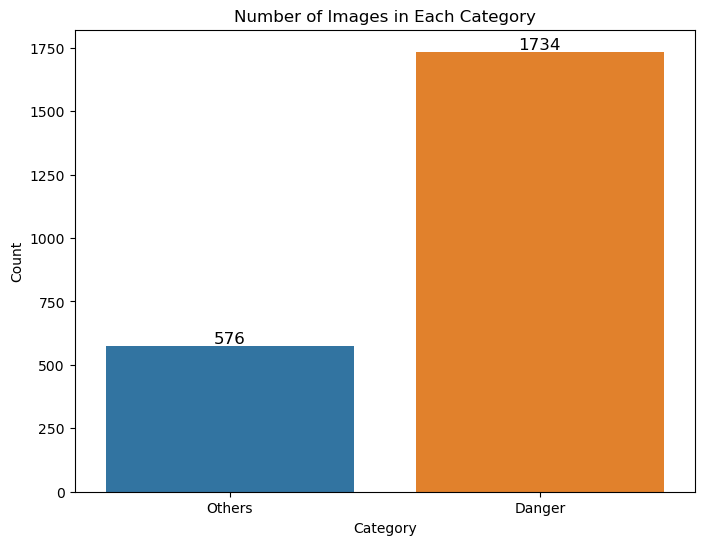

In [4]:
# Get the number of files in each directory
others_count = len(os.listdir('./data/Classes_with_video_content/Others'))
danger_count = len(os.listdir('./data/Classes_with_video_content/Danger'))

# Create a DataFrame for plotting
data = pd.DataFrame({'Category': ['Others', 'Danger'],
    'Count': [others_count, danger_count]})

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=data, hue='Category', legend=False)
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel('Count')

# Add the count value on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')
plt.show()

In [1]:
model2 = Sequential() # Initialization

model2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())  # Flattening 
model2.add(Dense(64, activation='relu'))    # Fully Connected Layer
model2.add(Dense(1, activation='sigmoid'))    # Sigmoid for binary classification 

# Compilation du modèle
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [ ]:
history2 = model2.fit(train_generator2, epochs=10, verbose=True, validation_data=validation_generator2)

Epoch 1/10
